# Основы машинного обучения (ИАД)
## НИУ ВШЭ, 2021-2022 учебный год

### Домашнее задание №8

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error

# Бустинг

## Градиентный бустинг своими руками (3 + 2* баллов)

Реализуйте алгоритм градиентного бустинга для регрессии. Напомним **основные формулы**.

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Следующий базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается следующим образом:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu$ — гиперпараметр learning rate, $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма, который можно найти по следующей формуле (обратите внимание на отсутствие $\nu$):

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

Можете принять $\gamma_N = 1$ для каждого $N$.

> Реализуйте нахождение оптимального $\gamma_N$ на каждом шаге, чтобы получить ещё 1 балл.


В качестве функции потерь возьмите **MSE**.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn` и методы оптимизации из различных библиотек.*

In [2]:
# это может помочь вам для поиска оптимальных gamma
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [3]:
class GradientBoosting:
    def __init__(self, n_estimators, max_depth, learning_rate=0.1):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        # your code here
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.bases = []
        self.gammas = []
        self.gamma = 1
        self.a = None
        
    def fit(self, x, y):
        """
        INPUT:
        x - np.array of shape (k, d)
        y - np.array of shape (k,)
        """
        # Здесь нам нужно проитерироваться по n_estimators и обучить
        # соответствующее количество деревьев с помощью _fit_predict_tree(),
        # правильно обновляя y_new
        # Деревья нужно где-то сохранить, чтобы затем использовать в predict()
        # your code here
        y_new = y
        tree = DecisionTreeRegressor(random_state=19052019, max_depth=self.max_depth)
        tree.fit(x, y_new)
        self.bases.append(tree)
        #f = lambda g: sum((np.array(self.bases[-1].predict(x))+(np.array(tree.predict(x))*g)-np.array(y))**2)
        f = lambda g: mean_squared_error(np.array(y_new), np.array(self.bases[-1].predict(x))+g*np.array(tree.predict(x)))
        self.gamma = minimize(fun=f, x0=1, bounds=((0.95,10),)).x
        self.gammas.append(self.gamma)
        self.a = self.gamma * self.learning_rate * tree.predict(x)
        for _ in range(self.n_estimators):
            y_new = y - self.a
            # your code here
            self.a += self._fit_predict_tree(x, y_new)

    def _fit_predict_tree(self, x, y):
        # Обучаем дерево и возвращаем его предикшн
        tree = DecisionTreeRegressor(random_state=19052019, max_depth=self.max_depth)
        # your code here
        tree.fit(x, y)
        #f = lambda g: sum((np.array(self.bases[-1].predict(x))+(np.array(tree.predict(x))*g)-np.array(y))**2)
        f = lambda g: mean_squared_error(np.array(y), np.array(self.bases[-1].predict(x))+g*np.array(tree.predict(x)))
        self.gamma = minimize(fun=f, x0=1, bounds=((0.95,10),)).x[0]
        self.bases.append(tree)
        self.gammas.append(self.gamma)
        return self.gamma * self.learning_rate * tree.predict(x)
        
    def predict(self, x):
        """
        INPUT:
        x - np.array of shape (m, d)
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        # Используем сохранённые деревья для расчёта агрегированного предикшна
        # your code here
        y_pred = sum([g * self.learning_rate * b.predict(x) for b, g in zip(self.bases, self.gammas)])
        return y_pred

Проверьте вашу реализацию на Boston dataset. 

> Подберите оптимальные гиперпараметры, чтобы победить RandomForestRegressor как в обычном случае, так и при нахождении оптимального шага **(не меняйте параметры сида)**. При необходимости воспользуйтесь GridSearch. За это вы получите ещё 1 балл.



In [4]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [5]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=4, n_estimators=640, random_state=19052019)

rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

9.63198271791959

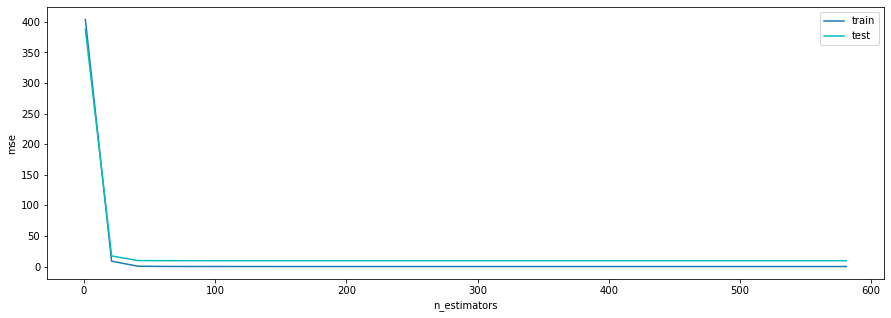

In [6]:
import matplotlib.pyplot as plt
np.random.seed(19052019)

# your code here
plt.figure(figsize=(15, 5))
n = np.arange(1, 600, 20)
test = []
train = []
# your code here
for i in n:
    gb = GradientBoosting(i, 6)
    gb.fit(X_train, y_train)
    train.append(mean_squared_error(y_train, gb.predict(X_train)))
    test.append(mean_squared_error(y_test, gb.predict(X_test)))
plt.plot(n, train, label="train")
plt.plot(n, test, color='c', label="test")
plt.xlabel("n_estimators")
plt.ylabel("mse")
plt.legend()
plt.show()

In [7]:
gb = GradientBoosting(500, 6)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
mean_squared_error(y_test, y_pred)

9.534537566107971

Для удобства проверяющего укажите, пожалуйста, реализовали ли вы нахождение оптимального шага?

- Да

## Прогнозируем задержки самолётов (2 балла)

Поработаем с задачей про задержки самолётов. На основании доступных данных о рейсе вам нужно определить, будет ли он задержан на 15 минут.
Воспользуйтесь любыми методами градиентного бустинга {`XGboost`, `catboost`, `LightGBM`} и `GridSearchCV` для достижения результата.

> Получите 1 балл за преодоление порога roc_auc_score 0.72 и ещё 1 балл за преодоление порога 0.74.



In [8]:
train = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_test.csv')

In [9]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [10]:
#conda install -c conda-forge py-xgboost

In [11]:
# Референс
from xgboost.sklearn import XGBClassifier

X_train = train[['Distance', 'DepTime']].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test[['Distance', 'DepTime']].values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

xgb_model = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
xgb_model.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, xgb_model.predict_proba(X_valid)[:, 1])

0.7043397869416514

In [12]:
X = train
y = X['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X = X.drop('dep_delayed_15min', 1)
X = pd.get_dummies(X, drop_first=True)
X.head()

,DepTime,Distance,Month_c-10,Month_c-11,Month_c-12,Month_c-2,Month_c-3,Month_c-4,Month_c-5,Month_c-6,...,Dest_TYS,Dest_VCT,Dest_VIS,Dest_VLD,Dest_VPS,Dest_WRG,Dest_WYS,Dest_XNA,Dest_YAK,Dest_YUM
0,1934,732,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1548,834,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1422,416,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1015,872,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1828,423,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [14]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from sklearn.metrics import make_scorer, roc_auc_score

cat = CatBoostClassifier(verbose=False, eval_metric='AUC', random_state=0, l2_leaf_reg=8)
roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True)
params = {'n_estimators':[200, 800],
        'max_depth':[5, 10],
        'learning_rate':[0.05, 0.1]}
grid = GridSearchCV(cat,params,scoring=roc_auc_scorer)
grid.fit(X_train_part, y_train_part)
best_estimator = grid.best_estimator_
print(grid.best_params_)

{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 800}


In [15]:
cat = best_estimator
cat.fit(X_train, y_train)
roc_auc_score(y_test, cat.predict_proba(X_test)[:, 1])

0.7425176167497033

# Кластеризация

## DBSCAN своими руками (3 + 2* баллов)


```
DBSCAN: Density-based spatial clustering of applications with noise
```


Реализуйте класс dbscan.

Алгоритм имеет два основных гиперпараметра:
1. `eps` &mdash; радиус рассматриваемой окрестности
2. `min_samples` &mdash; число соседей в окрестности

Для выполнения кластеризации DBSCAN точки делятся на основные точки, достижимые по плотности точки и выпадающие следующим образом:

- Точка $p$ является основной точкой, если по меньшей мере `min_samples` точек находятся на расстоянии, не превосходящем 
`eps` от неё. Говорят, что эти точки достижимы прямо из $p$.

-  Точка $q$ прямо достижима из $p$, если точка $q$ находится на расстоянии, не большем `eps`, от точки $p$, и $p$ — основная точка.
Точка $q$ достижима из $p$, если имеется путь 
$p_1,…,p_n$ где $p_1=p$ и $p_n=q$ , а каждая точка $p_{i+1}$ достижима прямо из $p_i$ (все точки на пути должны быть основными, за исключением $q$).

Все точки, не достижимые из основных точек, считаются выбросами.

Теперь, если $p$ является основной точкой, то она формирует кластер вместе со всеми точками (основными или неосновными), достижимыми из этой точки. Каждый кластер содержит по меньшей мере одну основную точку. Неосновные точки могут быть частью кластера, но они формируют его «край», поскольку не могут быть использованы для достижения других точек.


In [16]:
# Это может помочь вам для поиска дистанции между точками
from scipy.spatial import distance

In [17]:
# Рекомендации -- это только рекомендации
class dbscan:
    def __init__(self, eps, min_samples):
        # your code here
        self.eps = eps
        self.min_samples = min_samples
        
    def fit_predict(self, X):
        # Помечаем переданные точки, чтобы отличать уже кластеризованные
        # или являющиеся шумом от остальных
        # your code here
        self.X = X
        self.status = [0]*len(self.X)
        
        # Реализуем цикл по точкам, игнорирущий уже кластеризованные
        # your code here
        for i in range(len(self.X)):
            if self.status[i]==0:
        # Если точка ещё не кластеризована, с помощью range_query() ищем её соседей
        # your code here
                neighbours = self.range_query(i)
        # Если соседей недостаточно, то помечаем её выделенным под шум лейблом
        # (однако она ещё может попасть в какой-то иной кластер)
        # your code here
                if len(neighbours) < self.min_samples:
                    self.status[i] = -1
        # Если же соседей достаточно, будем строить от неё кластер с помощью grow_cluster()
        # your code here
                else:
                    self.status[i] = max(self.status)+1
                    self.grow_cluster(i, neighbours)
        return self.status
        
    def grow_cluster(self, root, neighbours):
        # В этой функции мы полностью строим кластер относительно переданной точки
        # Т.е. реализуем цикл по структуре данных, изначально состоящей из уже
        # известных соседей (neighbours) и в процессе пополняющейся
        # "соседями соседей" с помощью range_query()
        # your code here
        for n in neighbours:
            self.status[n] = self.status[root]
            self.grow_cluster(n, self.range_query(n))

    def range_query(self, x):
        """Возвращает точки на расстоянии <= eps от x"""
        # С помощью функции dist()
        # your code here
        neighbours = []
        for i in range(len(self.X)):
            if self.status[i]==0 and self.dist(np.array([tuple(X[i]), tuple(X[x])]), np.array([tuple(X[i]), tuple(X[x])]))<=self.eps:
                neighbours.append(i)
        return neighbours
    
    @staticmethod
    def dist(a, b):
        """Метрика расстояния"""
        # Попробуйте что-нибудь из scipy.spatial.distance
        # Базовый вариант -- Евклидова метрика
        # your code here
        return distance.cdist(a, b, 'euclidean')[0, 1]

Проверим себя на простом примере:

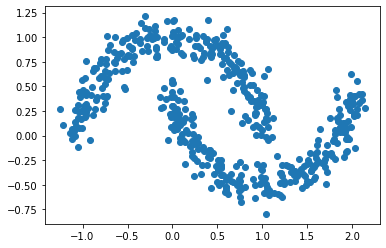

In [18]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd

X, _ = make_moons(n_samples=500, noise=0.1, random_state=1234)
plt.scatter(X[:,0], X[:,1])
plt.show()

Кластеризуйте это с помощью своей версии DBSCAN:

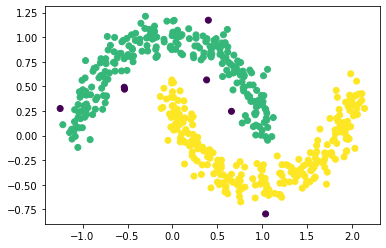

In [19]:
# your code here
clf = dbscan(0.15, 3)
plt.scatter(X[:,0], X[:,1], c=clf.fit_predict(X))
plt.show()

Референс:

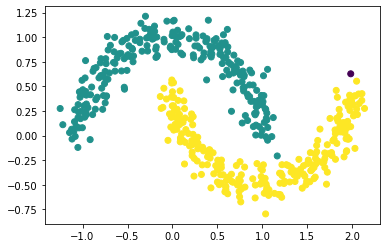

In [20]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)
plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()


> Получите 1 балл за ещё один интересный пример кластеризации (в качестве референса используйте предоставленное изображение. Нужно несколько интересных соседствующих форм):



In [21]:
# your code here


Или хотя бы что-нибудь такое: 

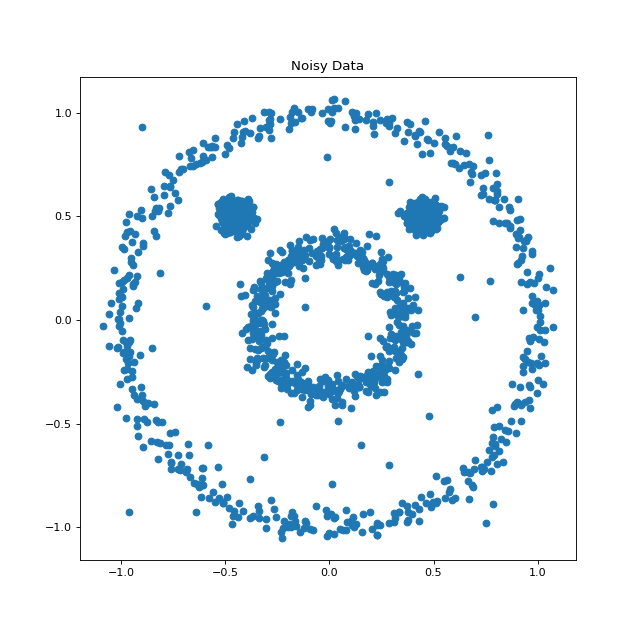

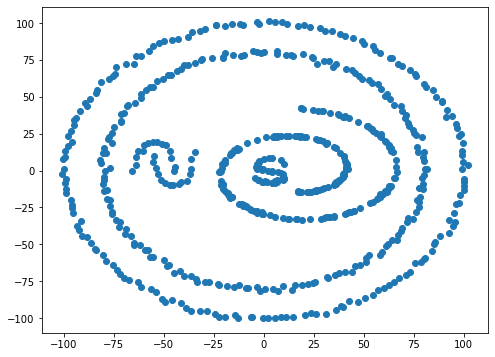

In [22]:
# your code here
from sklearn.datasets import make_s_curve
from sklearn.datasets import make_circles
from sklearn.datasets import make_swiss_roll

plt.figure(figsize=(8, 6))
X, _ = make_moons(n_samples=30, noise=0.05, random_state=1234)
X[:,0] *=10
X[:,1] *=20
X[:,0] -=55
temp, _ = make_s_curve(40, noise=0.1, random_state=1234)
X = np.concatenate((X, np.array([temp[:,0]*7+3, temp[:,2]*4]).transpose()), axis=0)
temp, _ = make_swiss_roll(200, noise=0.1, random_state=1234)
X = np.concatenate((X, np.array([temp[:,0]*4+16, temp[:,2]*3]).transpose()), axis=0)
temp, _ = make_circles(350, noise=0.01, random_state=1234)
X = np.concatenate((X, np.array([temp[:,0]*100, temp[:,1]*100]).transpose()), axis=0)
plt.scatter(X[:,0], X[:,1])
plt.show()

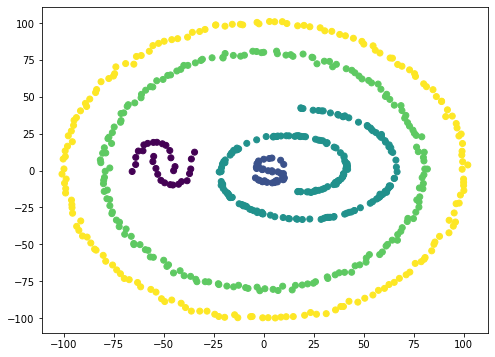

In [23]:
plt.figure(figsize=(8, 6))
clf = dbscan(9, 4)
plt.scatter(X[:,0], X[:,1], c=clf.fit_predict(X))
plt.show()


> Получите ещё 1 балл, если время работы вашего алгоритма больше референсного не более чем в 100 раз с учётом погрешности 3% от вашего времени:



In [24]:
%%time
%%capture
clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X[:100:])

Wall time: 6.01 ms


In [25]:
%%time
%%capture
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X[:100:])

Wall time: 224 ms


## Применяем DBSCAN (3 балла)

__[1.5 балла]__ Возьмите колонки `Distance` и `DepTime` (из датасета о задержках самолётов). Запустите на тренировочной выборке на них DBSCAN. Нарисуйте облоко рассеивания с получившимися кластерами. Насколько много их вышло? 

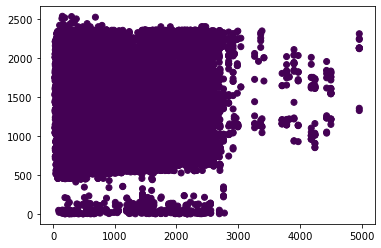

In [26]:
# your code here  ლ(ಠ益ಠლ)
X = train[['Distance', 'DepTime']].values
clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)
plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

*Кластер получился один, потому что eps слишком маленький для таких данных*

Попробуйте перебрать параметры `eps` и `min_samples` по решётке и нарисовать для каждой пары облако рассеивания. При каких параметрах шумовых точек оказывается больше всего? Почему так происходит? 

__Ответ:__ 

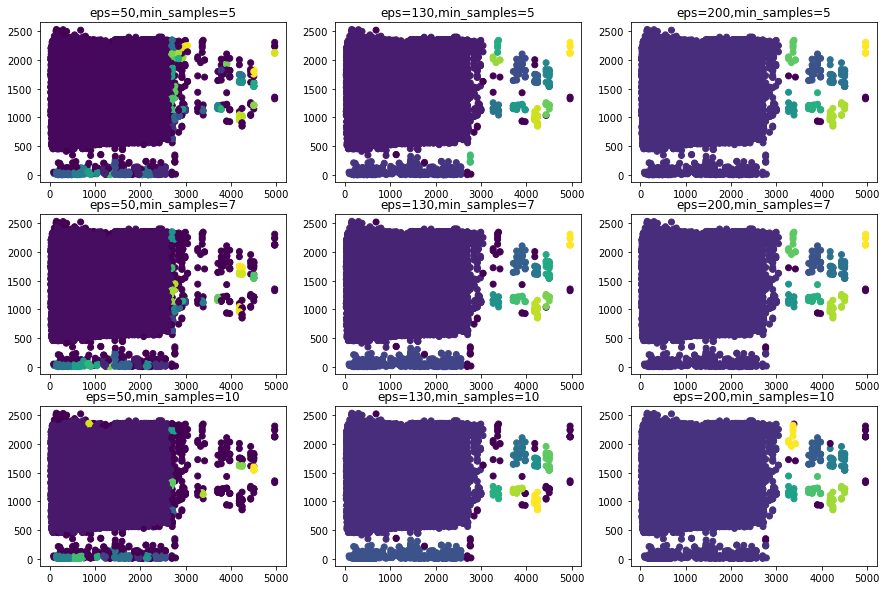

In [27]:
# your code here   ⟅⎛ꌩωꌩ⎞⟆
#temp = X[:50000:]
eps = [50, 130, 200]
min_samples = [5, 7, 10]
fig, ax = plt.subplots(nrows=3, ncols=3, figsize = (15, 10))
for i in range(len(eps)):
    for j in range(len(min_samples)):
        clusters = DBSCAN(eps=eps[i], min_samples=min_samples[j]).fit_predict(X)
        ax[j][i].scatter(X[:,0], X[:,1], c=clusters)
        ax[j][i].title.set_text("eps="+str(eps[i])+",min_samples="+str(min_samples[j]))
plt.show()

*Больше всего шумовых точек при маленьком eps и большом min_samples, потому что маленький eps сужает круг возможных соседей, поэтому все меньше точек могут найти свой класс. А большой min_samples так же ужесточает правила попадания в класс, потому что меньше точек являются основными и могут формировать кластер.*

__[1.5 балла]__ Добавьте в датасет новую категориальную переменную: номер кластера из DBSCAN и обучите Catboost со своими лучшими гиперпараметрами. Улучшилось ли качество модели на тестовой выборке? Как думаете, почему? 

In [28]:
# your code here  ¯\_(ツ)_/¯
clusters = DBSCAN(eps=130, min_samples=10).fit_predict(X)
X = train
y = X['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X = X.drop('dep_delayed_15min', 1)
X['dbscan'] = clusters
X = pd.get_dummies(X, columns=['dbscan'])
X = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [29]:
cat = best_estimator
cat.fit(X_train, y_train)
roc_auc_score(y_test, cat.predict_proba(X_test)[:, 1])

0.7415001402670947

__Ответ:__ *Качество модели немного ухудшилось. Возможно, были взяты неправильные параметры DBSCAN(они были выбраны по тому, какое разделение визуально выглядело лучше всего) или вещественные признаки, по которым производилась классификация, только ухудшили ответ, ведь классификация по этим двум признакам, которая проводилась в референсе 2 задания, давала не самое лучшее качество.*

# Небольшие подарочки

**+0.1 балла** за фотографию того, как вы проводите лето на открытом воздухе

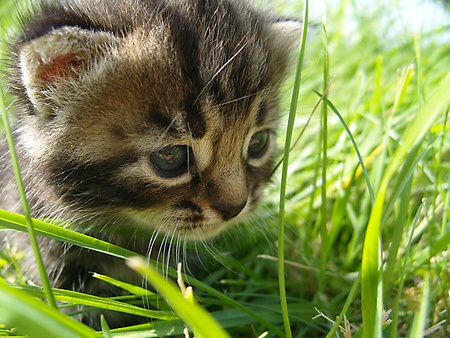

**+0.1 балла** за смешной мем по машинному обучению

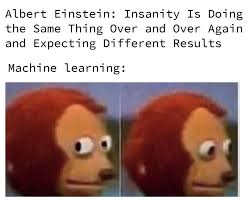

**+0.1 балла** за развернутый отзыв о курсе: ваших впечатлениях, сложностях и радостях, любимых темах и т.д.

*В целом, курс показался очень интересным, вся информация была для меня новой. Лекции и семинары были четкими и понятными. Иногда было тяжело понимать, о чем говорится в лекциях или ПР, потому что у большинства понятий есть несколько альтернативных названий и их очень легко перепутать. Для меня это было огромной проблемой. Также некоторые темы были будто не до конца разобраны, из-за этого появлялись проблемы во время выполнения дз и других работ. Ну а так не было ничего прям очень сложного и непостижимого, просто иногда не хватало времени сразу со всем хорошо разобраться.*